<a href="https://colab.research.google.com/github/kdh4672/economy_ai/blob/main/EC5320_2022_1_Week1_CNN_Classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EC5320 Week1b codes

2021.3.7.<br>

This notebook uses CNN to classify image classes.

Main source of codes: <br>

https://github.com/fastai/fastbook/blob/master/01_intro.ipynb

# Install and import libraries

In [ ]:
# upgrade fastai to the most recent version (v. 2.5.3)

%%capture
!pip install fastai --upgrade

In [ ]:
import fastai
print(fastai.__version__)

from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.collab import *
#from fastai.tabular.all import * 

2.5.3


In [ ]:
%%capture
!pip install -Uqq fastbook

In [ ]:
from fastbook import *

In [ ]:
from google.colab import files

In [ ]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)


# PART 1: Predict cat v.s. dog using Oxford pet image dataset

## 1.1 Download pet images

In [ ]:
path = untar_data(URLs.PETS)/'images'

## 1.2 Train CNN model

In [ ]:
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet18, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.183430,0.026582,0.990528,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.051388,0.019732,0.991881,00:46


## 1.3 Confusion matrix and images with top losses

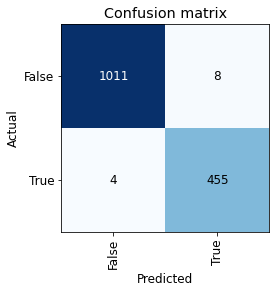

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

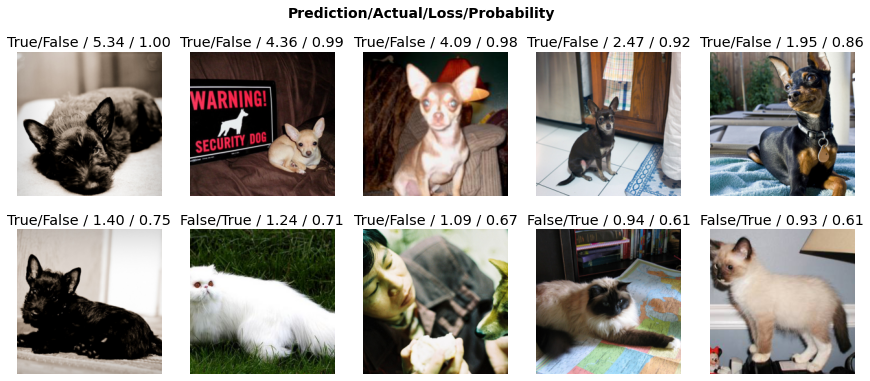

In [ ]:
plot_top_losses_fix(interp, 10, nrows=2) ## predicted / actual

## 1.4 Test using your own image

In [ ]:
# upload an image file

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file: {name}'.format(name=fn))

Saving dog.jpg to dog.jpg
User uploaded file: dog.jpg


In [ ]:
# get the file name of the uploaded file 

img_name = list(uploaded.keys())[0]

Is this a cat?: False
Probability it's a cat: 0.00


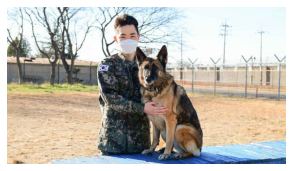

In [ ]:
# predict

img = PILImage.create(uploaded[img_name])
is_cat,_,probs = learn.predict(img)

img.show()

print("Is this a cat?: {}".format(is_cat))
print("Probability it's a cat: {:.2f}".format(probs[1].item()))

# PART 2: Do your own classification using internet images

## 2.1 As an example, download images of a keyword from internet

In [ ]:
img_keyword = 'grizzly bear'

img_urls = search_images_ddg(img_keyword, max_images=200)

print("number of image urls found: {}".format(len(img_urls)))
print(img_urls[0])

number of image urls found: 275
http://i.huffpost.com/gen/1227495/images/o-GRIZZLY-BEAR-facebook.jpg


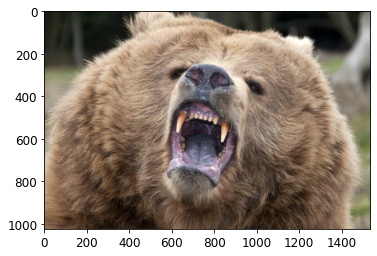

In [ ]:
# download urls and show image
download_url(img_urls[0], 'images/test_img.jpg')
im = Image.open('images/test_img.jpg')

from matplotlib.pyplot import imshow
imshow(im)

## 2.2 Download images of each class

In [ ]:
# WRITE YOUR CLASSES AND SUBFOLDER HERE

my_classes = ['adults', 'kids']
path = Path('people')

Path('people')

In [ ]:
# download images

if not path.exists():
    path.mkdir()
    for each_class in my_classes:
        dest = (path/each_class)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(each_class, max_images=200)
        print('{} image urls found for the class: {}'.format(len(results), each_class))
        print('downloading...')
        download_images(dest, urls=results)

254 image urls found for the class: adults
downloading...
200 image urls found for the class: kids
downloading...


In [ ]:
# check folders
path.ls()

(#2) [Path('people/kids'),Path('people/adults')]

In [ ]:
# get image file paths
img_f_paths = get_image_files(path)
img_f_paths

(#435) [Path('people/kids/00000074.jpg'),Path('people/kids/00000103.JPG'),Path('people/kids/00000095.jpg'),Path('people/kids/00000129.jpg'),Path('people/kids/00000143.jpg'),Path('people/kids/00000109.jpg'),Path('people/kids/00000037.jpg'),Path('people/kids/00000070.jpg'),Path('people/kids/00000081.jpg'),Path('people/kids/00000098.jpg')...]

In [ ]:
# find bad quality images
bad_image_paths = verify_images(img_f_paths)
bad_image_paths

(#3) [Path('people/kids/00000086.jpg'),Path('people/kids/00000001.jpg'),Path('people/adults/00000066.jpg')]

In [ ]:
# remove these bad images from path list
bad_image_paths.map(Path.unlink);

## 2.3 Prepare dataset for CNN learning

In [ ]:
# dataset settings

dataset_settings = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
# create dataset

my_first_dataset = dataset_settings.dataloaders(path)

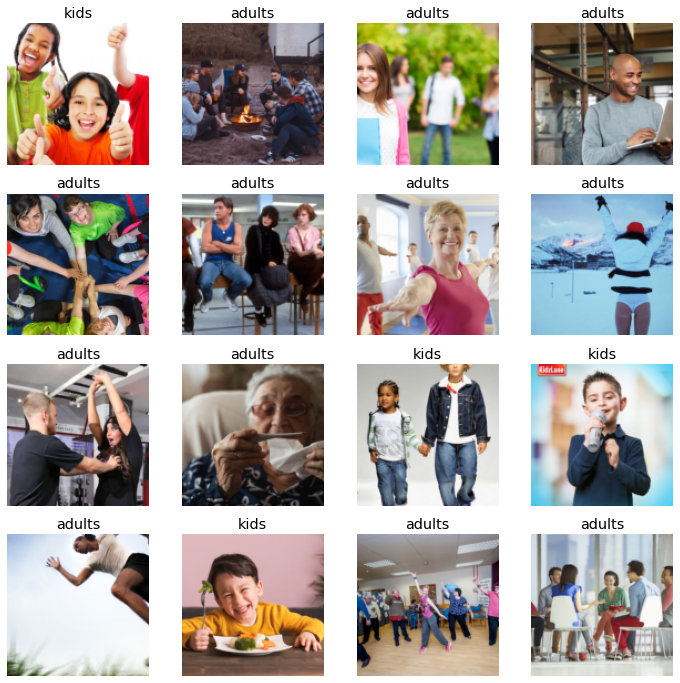

In [ ]:
# show image examples

my_first_dataset.valid.show_batch(max_n=16, nrows=4)

## 2.4 Train CNN model

In [ ]:
learn = cnn_learner(my_first_dataset, resnet50, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152, mean_squared_error, accuracy, error_rate
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.011841,1.030455,0.674419,00:15


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,accuracy,time
0,0.887068,2.332413,0.511628,00:15


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## 2.5 Confusion matrix and images with top losses

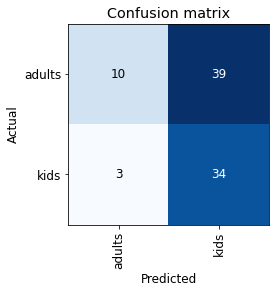

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

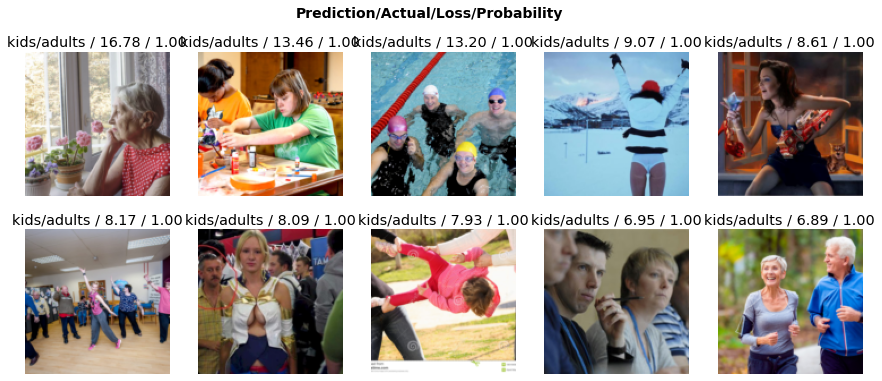

In [ ]:
plot_top_losses_fix(interp, 10, nrows=2)